# TP2 - Rossmann Store Sales
Francisco Ledesma

### 1 - ¿Qué son los Entity Embeddings y cómo se relacionan con las variables categóricas?

Embeddings es la transformacion de un espacio multidimensional a un vector continuo.
Esto es bueno por que las redes neuronales trabajan mejor con una variable continua que con las discretas. Esto se debe a que las neuronas hacen una transformacion lineal con una no linealidad dando un resultado que describe el mundo continuo. La idea de aplicar dicha transformacion es convertir las variables categoricas en variables continuas denominadas 'Entity Embeddings'

### 2 - Explique la métrica utilizada en la competencia.
la métrica utilizada es RMSPE: <br>
$$
\textrm{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

donde:

- $y_i$ las ventas de un día particular de un store
- $\hat{y}_i$ ventas estimadas por el modelo
- $n$ es el número de predicciones realizadas

La metrica RMSPE es muy similar al RMSE, la diferencia radica en que esta metrica se inmuniza ante sesgos provocados por el balance de locales con mas o menos ventas. Ademas, los locales con mayor cantidad de ventas podrian provocar que la red no se adapte bien a los locales mas pequeños con un menor numero de ventas.
Esto lo hace dividiendo la diferencia entre el valor predecido con el valor real por el valor real, es decir, normalizando el error.

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.utils import to_categorical
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [2]:
df = pd.read_feather('feathers/train_normalized_data.fth')
df_test = pd.read_feather('feathers/test_normalized_data.fth')

In [3]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']
# cat_vars = ['Store', 'DayOfWeek']

In [4]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']
# contin_vars = ['BeforeStateHoliday_bool', 'Max_TemperatureC']

In [5]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]
uniques.T

,uniques
Store,1115
DayOfWeek,7
Year,3
Month,12
Day,31
StateHoliday,4
CompetitionMonthsOpen,25
Promo2Weeks,26
StoreType,4
Assortment,3


# Asignación de dimensión de embeddings

In [6]:
cat_var_dict = {
    'Store': 1115, 
    'DayOfWeek': 7, 
    'Year': 3, 
    'Month': 12,
    'Day': 31, 
    'StateHoliday': 4, 
    'CompetitionMonthsOpen': 25,
    'Promo2Weeks': 26,
    'StoreType': 4,
    'Assortment': 3,
    'PromoInterval': 4,
    'CompetitionOpenSinceYear': 21,
    'Promo2SinceYear': 8, 
    'State': 12,
    'Week': 52,
    'Events': 22,
    'Promo_fw': 6,
    'Promo_bw': 6,
    'StateHoliday_bool_fw': 3,
    'StateHoliday_bool_bw': 3,
    'SchoolHoliday_fw': 8,
    'SchoolHoliday_bw': 8}

In [7]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)
    print()

Store 1115 1115 [   0    1    2 ... 1112 1113 1114]

DayOfWeek 7 7 [0 1 2 3 4 5 6]

Year 3 3 [0 1 2]

Month 12 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Day 31 31 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]

StateHoliday 4 4 [0 1 2 3]

CompetitionMonthsOpen 25 25 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]

Promo2Weeks 26 26 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]

StoreType 4 4 [0 1 2 3]

Assortment 3 3 [0 1 2]

PromoInterval 4 4 [0 1 2 3]

CompetitionOpenSinceYear 21 21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]

Promo2SinceYear 8 8 [0 1 2 3 4 5 6 7]

State 12 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Week 52 52 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]

Events 22 22 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 

## Definición de modelo

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2

In [9]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

In [10]:
add_customers = True
log_output = True
output_activation = 'linear'
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

In [11]:
first_hidden_units = 1500
second_hidden_units = 500
l2_lambda = 1e-4

merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)
x = Dense(first_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(merged)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)
x = Dense(second_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)

output_1 = Dense(1, name='Sales', activation=output_activation)(x)
output_2 = Dense(1, name='Customers', activation=output_activation)(x)

In [12]:
if add_customers:
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1, output_2])
else: 
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1])
# Descomentar para ver
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Year_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Month_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                              

In [13]:
model.save_weights('weights/initial_weights.hdf5')

In [14]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [15]:
stores_mean = {}
for store, g_df in df_train.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()
    
df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)

df_train.loc[:, 'Sales_store'] = df_train['Sales'] - df_train['mean_by_store']
df_val.loc[:, 'Sales_store'] = df_val['Sales'] - df_val['mean_by_store']

C:\Users\FranciscoDanielLedes\AppData\Local\Temp\ipykernel_12192\1524812702.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
C:\Users\FranciscoDanielLedes\AppData\Local\Temp\ipykernel_12192\1524812702.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)
C:\Users\FranciscoDanielLedes\AppData\Local\Temp\ipykernel_12192\1524812702.py:8: SettingWithCopyWarning: 
A

In [16]:
from tensorflow.keras import backend as K

In [17]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))
def get_metric(df, sales_):
    return np.sqrt((((df['Sales'] - sales_)/df['Sales'])**2).mean())

In [18]:
get_metric(df_val, df_val['mean_by_store'])

0.3071746085338871

In [19]:
all_vars = cat_vars + contin_vars
X_train = np.hsplit(df_train[all_vars].values, len(all_vars))
X_val = np.hsplit(df_val[all_vars].values, len(all_vars))
X_test = np.hsplit(df_test[all_vars].values, len(all_vars))

In [20]:
if add_customers:
    y_out_columns = ['Sales', 'Customers']
else:
    y_out_columns = ['Sales_store']
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
    y_mean = df_train[y_out_columns].mean().values
    y_std = df_train[y_out_columns].std().values
#     y_train = (df_train[y_out_columns].values - y_mean)/y_std
#     y_val = (df_val[y_out_columns].values - y_mean)/y_std
    y_max = df_train[y_out_columns].max().values
    y_train = df_train[y_out_columns].values/y_max
    y_val = df_val[y_out_columns].values/y_max
y_train = np.hsplit(y_train, y_train.shape[1])
y_val = np.hsplit(y_val, y_val.shape[1])

c:\Users\FranciscoDanielLedes\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [21]:
lr = 0.00008
model.compile(optimizer=Adam(lr=lr), metrics=['mse', rmspe], loss='mse')

c:\Users\FranciscoDanielLedes\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
if add_customers:
    checkpoint = ModelCheckpoint('weights/bestmodel.hdf5', monitor='val_Sales_mse', verbose=1, save_best_only=True)
else:
    checkpoint = ModelCheckpoint('weights/bestmodel.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [23]:
epochs = 10
batch_size = 128
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], verbose=2)

Epoch 1/10

Epoch 1: val_Sales_mse improved from inf to 0.00034, saving model to weights\bestmodel.hdf5
6361/6361 - 360s - loss: 0.0481 - Sales_loss: 0.0016 - Customers_loss: 0.0017 - Sales_mse: 0.0016 - Sales_rmspe: 0.0311 - Customers_mse: 0.0017 - Customers_rmspe: 0.0372 - val_loss: 0.0049 - val_Sales_loss: 3.4253e-04 - val_Customers_loss: 4.1425e-04 - val_Sales_mse: 3.4253e-04 - val_Sales_rmspe: 0.0222 - val_Customers_mse: 4.1425e-04 - val_Customers_rmspe: 0.0274 - 360s/epoch - 57ms/step
Epoch 2/10

Epoch 2: val_Sales_mse improved from 0.00034 to 0.00028, saving model to weights\bestmodel.hdf5
6361/6361 - 348s - loss: 0.0017 - Sales_loss: 2.3414e-04 - Customers_loss: 2.7175e-04 - Sales_mse: 2.3414e-04 - Sales_rmspe: 0.0188 - Customers_mse: 2.7175e-04 - Customers_rmspe: 0.0231 - val_loss: 8.6004e-04 - val_Sales_loss: 2.8023e-04 - val_Customers_loss: 2.4798e-04 - val_Sales_mse: 2.8023e-04 - val_Sales_rmspe: 0.0198 - val_Customers_mse: 2.4798e-04 - val_Customers_rmspe: 0.0211 - 348s/ep

In [24]:
import matplotlib.pyplot as plt

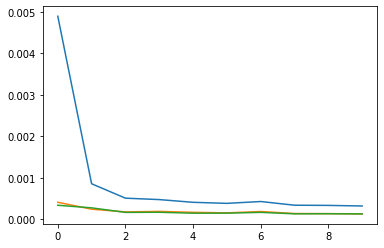

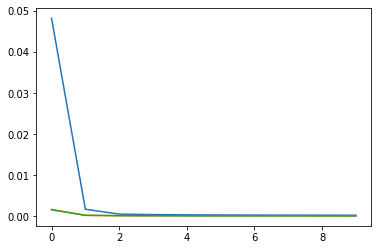

In [25]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_Customers_mse'])
plt.plot(history.history['val_Sales_mse'])
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['Customers_mse'])
plt.plot(history.history['Sales_mse'])

## Métrica
$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [26]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 7s 7ms/step - loss: 3.2508e-04 - Sales_loss: 1.3477e-04 - Customers_loss: 1.3427e-04 - Sales_mse: 1.3477e-04 - Sales_rmspe: 0.0137 - Customers_mse: 1.3427e-04 - Customers_rmspe: 0.0154


[0.0003250768349971622,
 0.0001347742072539404,
 0.00013427498925011605,
 0.0001347742072539404,
 0.01369885727763176,
 0.00013427498925011605,
 0.01542462408542633]

In [27]:
model.load_weights('weights/bestmodel.hdf5')
model.evaluate(X_val, y_val)

944/944 [==============================] - 7s 7ms/step - loss: 3.2508e-04 - Sales_loss: 1.3477e-04 - Customers_loss: 1.3427e-04 - Sales_mse: 1.3477e-04 - Sales_rmspe: 0.0137 - Customers_mse: 1.3427e-04 - Customers_rmspe: 0.0154


[0.0003250768349971622,
 0.0001347742072539404,
 0.00013427498925011605,
 0.0001347742072539404,
 0.01369885727763176,
 0.00013427498925011605,
 0.01542462408542633]

In [28]:
if log_output:
    if add_customers:
        y_pred = np.exp(model.predict(X_val, verbose=1)[0][:, 0]*max_log_y[0])
        y_pred_test = np.exp(model.predict(X_test, verbose=1)[0][:, 0]*max_log_y[0])
    else:
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)[:,0]
        y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)[:,0]
else:
    if add_customers:
        y_pred = (model.predict(X_val, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
        y_pred_test = (model.predict(X_test, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
    else:
#         y_pred = model.predict(X_val, verbose=1)[:,0]*y_std + y_mean
#         y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_std + y_mean
        y_pred = model.predict(X_val, verbose=1)[:,0]*y_max
        y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_max
y_pred_test[df_test['Open'] == 0] = 0

1284/1284 [==============================] - 8s 6ms/step


In [29]:
np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))

0.12952431421939176

In [30]:
final = pd.DataFrame(data=y_pred_test,columns=['Sales'])
final.index.name = 'Id'
final.index += 1
final.to_csv('result/sample_submission_final.csv', sep=',', encoding='utf-8')


## Analisis de embedings

In [31]:
def plot_embed(layer_name, cat_names):
    Y = model.get_layer(layer_name).get_weights()[0]
    print(Y.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    for i, txt in enumerate(cat_names):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

(7, 7)


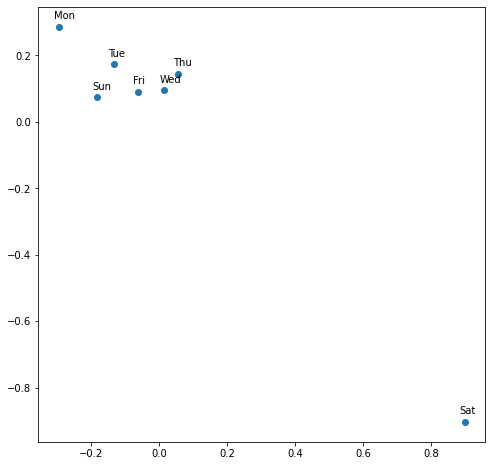

In [33]:
model.load_weights('weights/bestmodel.hdf5')
plot_embed('DayOfWeek_Embed', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])

(12, 12)


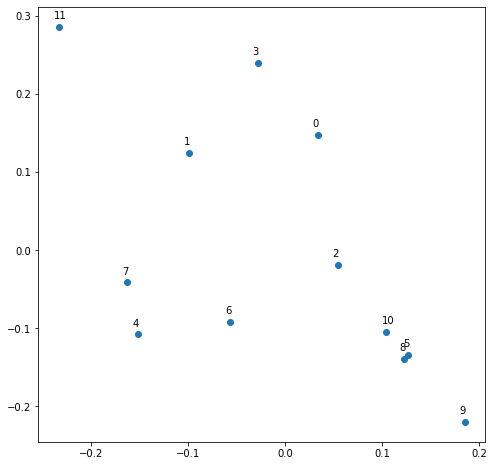

In [34]:
plot_embed('Month_Embed', list(range(12)))

## Store embeddings

In [35]:
submodel = Model(cat_var_inputs + cont_vars_inputs, merged)

In [36]:
submodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Year_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Month_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                            

In [ ]:
submodel.save('weights/embeddings_model.hdf5')